# Lesson1 手書き文字認識をしよう（ニューラルネットワーク入門）

## 目次

- Section3 テクニック・発展内容
  - 3.1 前処理
  - 3.2 勾配に関するテクニック
    - 3.2.1 最適化アルゴリズム (optimizer)
    - 3.2.2 活性化関数 (activation)
    - 3.2.3 初期化 (initializer)
  - 3.3 過学習に関するテクニック
    - 3.3.1 正則化 (regularization)
    - 3.3.2 早期終了 (early stopping)
    - 3.3.3 ドロップアウト (dropout)
  - 3.4 確認問題

## Section3 テクニック・発展内容

### 3.1 前処理

学習の高速化や性能向上などのために入力データを変換する前処理を行うことがあります。

そのひとつに、データを学習において取り扱いやすいよう、特定の範囲にデータが収まるように変換する**スケーリング**があります。

例えば、mnistの入力画像の各ピクセルの値は0~255の範囲の整数値ですが、それぞれ255で割ることで値を0~1の浮動小数点数に収めます。

```py
x_train, x_test = x_train/255, x_test/255
```

他にも平均や分散を特定の値にする**正規化**やデータの各要素間の相関を取り除く**白色化**、またデータ全体を考慮した**バッチ正規化**といった前処理もあります。

前処理としてはこれらの手法の方が圧倒的に有意義ですが、次のLessonで説明します。

### 3.2 勾配に関するテクニック

MLPにおいてモデルのパラメータを適切に学習することが最大の目的です。

つまり、パラメータの更新量が適切に定まることは最も重要と言えるわけです。

実はこのパラメータの更新量は**勾配**（＝損失関数のパラメータに関する微分）と呼ばれるものによって決定されますが、

この勾配は大きくなりすぎたり、小さくなりすぎたりしやすいもので、適切に取り扱う必要があります。

ここでは、そうしたパラメータ更新量や勾配を適切なものとするためのテクニックを3つ（optimizer, activation, initialization）ほど見ていきましょう。

#### 3.2.1 最適化アルゴリズム (optimizer)

まずはパラメータの学習に直接効いてくる、パラメータの更新方法、つまり最適化アルゴリズムから見ていきましょう。

最適化アルゴリズムには様々なものがあり、Kerasでも多くのoptimizerの選択肢があります。

まずは、最も基本的な**最急降下法**と**確率的勾配降下法(Stochastic Gradient Descent, SGD)**について解説します。

その後に、他のoptimizerについて解説します。

Kerasの公式HP: https://keras.io/ja/optimizers/

##### 最急降下法

最急降下法は勾配降下法とも呼ばれる、基本的な最適化アルゴリズムで、1階の微分である勾配のみを用いて最適化を行います。

パラメータ$\boldsymbol{w}$の$t$回目の更新を、損失関数を$\mathrm{E}$として、

$$
\boldsymbol{w}^{(t+1)} \leftarrow \boldsymbol{w}^{(t)} - \eta\nabla\mathrm{E}(\boldsymbol{w}^{(t)}) \quad \left(\nabla\mathrm{E}(\boldsymbol{w}^{(t)}) = \left.\frac{\partial \mathrm{E}(\boldsymbol{w})}{\partial \boldsymbol{w}}\right|_{\boldsymbol{w}=\boldsymbol{w}^{(t)}}\right)
$$

のように行います。$\eta$は**学習率**と呼ばれるパラメータで、明示的に指定する必要があります。

なお、最急降下法では損失関数の計算には常に全訓練データを用い、

$$
\mathrm{E}(\boldsymbol{w}^{(t)})=\sum_n \mathrm{E}_n(\boldsymbol{w}^{(t)})
$$

として計算します。（$\mathrm{E}_n$はn番目の訓練データによる損失関数）

上の更新式についてイメージを説明すると

* $\nabla\mathrm{E}(\boldsymbol{w}^{(t)})$：パラメータの空間で損失関数が最も増加する方向（これを**勾配**といいます）
* $\eta$：パラメータの空間で損失関数が最も減少する方向$\left(-\nabla\mathrm{E}(\boldsymbol{w}^{(t)})\right)$にどれだけ進むかの比率

となっています。

この最急降下法はほとんどの最適化手法の基本形になっているので、イメージを抑えておき、各手法の独自性と照らし合わせてみてください。

##### SGD

SGDは最もオーソドックスなMLPのオンライン学習手法です。

パラメータの更新を、

$$
\boldsymbol{w}^{(t+1)} \leftarrow \boldsymbol{w}^{(t)} - \eta\nabla\mathrm{E}^{(t)}(\boldsymbol{w}^{(t)}) \quad \left(\nabla\mathrm{E}^{(t)}(\boldsymbol{w}^{(t)}) = \left.\frac{\partial \mathrm{E}^{(t)}(\boldsymbol{w})}{\partial \boldsymbol{w}}\right|_{\boldsymbol{w}=\boldsymbol{w}^{(t)}}\right)
$$

のように行います。ここで、

$$
\mathrm{E}^{(t)}(\boldsymbol{w}^{(t)})=\frac{1}{|\mathfrak{B}^{(t)}|}\sum_{n\in\mathfrak{B}^{(t)}}\mathrm{E}_n(\boldsymbol{w}^{(t)})
$$

です。

このように、各更新毎にランダムにミニバッチ（＝訓練データの抜粋、部分集合）$\mathfrak{B}^{(t)}$を構成し、その平均損失を使用することがSGDの特徴です。

Kerasでは以下のクラスを使用します。

```py
keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
```

引数は、

* lr: 学習率、0以上の実数
* momentum: モーメンタム、0以上の実数（前回のパラメータ更新量を反映させる比率（3.2.2で説明））
* decay: 更新毎の学習率の減衰率、0以上の実数
* nesterov: Nesterov momentumを適用するかどうか（Trueならモーメンタム項の計算を1ステップ先読みして評価します（3.2.2で説明））

これはcompile関数の引数として、`optimizer='sgd'`と指定することで使用できます。

もしデフォルトでない引数でSGDを使用する場合は`optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)`などと指定してください。

#### その他の最適化アルゴリズムを考えるにあたって

SGDでは学習率は明示的に与える必要がありました。しかし、どのような学習率が最適なのでしょうか？

確かに学習率が大きければ、勾配方向への移動距離が大きくなり、より早く学習できそうです。

しかし学習が進めば、次第に「最適解」に近づくことが期待されますが、このとき学習率が大きすぎると「通り過ぎる」可能性もあります。

（ゴルフのカップ付近でドライバーを振る人はいないわけです）

したがって、学習の序盤は大きな学習率で素早く解の付近にたどり着き、次第に学習率を減らして慎重に解に位置を合わせたい訳です。

しかし、こうした学習率の調整を手動で行うことは困難です。そこで、学習率の調整が組み込まれた最適化手法が複数提案されています。

また、単純なSGDでは、勾配が小さい平坦な場所に来ると更新がほとんど行われなくなってしまうといった問題もありますが、

こちらについても同時に対処がなされています。

Kerasでは以下で紹介する、より便利な最適化アルゴリズムも、compile時にoptimizerパラメータを変更するだけで簡単に使用可能です。

##### Momentum

前ステップの更新を加味することで、 勾配の変化を滑らかにします。

これによって、「通り過ぎる」ことによる行ったり来たりの振動を抑制することができます。

また、勾配変化の少ない（パラメータ空間内の）通常の斜面においては、

他の勾配変化の大きい斜面と比較して学習率が上昇し、加速的に学習が進むという効果を持っています。

Momentumでは前ステップの更新量を加味する割合を'momentum'として指定します。

なお、`momentum=0`では通常のSGDと一致することもあり、KerasではSGDクラスのmomentum引数を調整することで使用できます。

通常は`momentum=0.9`程度に設定します。

```py
# Momentumの実装例
from keras.optimizers import SGD
model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.01, momentum=0.9, decay=0.0, nesterov=False))
```

<small>
<参考>

更新式は次の通りです。($\boldsymbol{w}^{(t)}$：$t$回目の更新時のパラメータ、$\eta$：学習率（引数lr）、$\mu$：前ステップ加味割合（引数momentum）)

$$
    \boldsymbol{w}^{(t+1)} = \boldsymbol{w}^{(t)} + \Delta\boldsymbol{w}^{(t)} \\
    \Delta\boldsymbol{w}^{(t)} = \mu\Delta\boldsymbol{w}^{(t-1)} - (1-\mu)\eta\nabla\mathrm{E}(\boldsymbol{w}^{(t)})
$$

なお、Nesterov's accelerated gradient method (NAG)、つまり'nesterov=True'のときは、

$$
    \Delta\boldsymbol{w}^{(t)} = \mu\Delta\boldsymbol{w}^{(t-1)} - (1-\mu)\eta\nabla \mathrm{E}(\boldsymbol{w}^{(t)}+\mu\boldsymbol{w}^{(t-1)})
$$

と更新式が変化し、$t+1$での位置を概算した$\boldsymbol{w}^{(t)}+\mu\boldsymbol{w}^{(t-1)}$での勾配を計算し、より変化を緩やかにします。
</small>

##### Adagrad

これまでは全パラメータに対して一様な学習率が設定されていましたが、各方向に対して勾配が異なることを考慮すれば、

各パラメータごとに学習率を変化させることができると、より効率的な最適化ができそうです。

AdaGradでは、全体の学習率を各方向ごとに過去の勾配の累積で割り引くことで、

勾配が大きかった方向の学習率を下げ、小さかった方向の学習率を上げる工夫を導入しています。

これによって、たとえ鞍点のようなある方向には勾配が小さいような状況でも、学習が進みやすくなります。

Kerasでは,`keras.optimizers.Adagrad`クラスを使用し、通常は学習率として`lr=0.01`程度を用います。

なお、AdaGradは学習の初期に勾配が大きいとすぐに更新量が小さくなってしまい、学習がストップしてしまうという欠点があるため、

学習率の選択、また重みの初期値の選択は慎重に行う必要があるという欠点をもっていることは気にしておくとよいでしょう。

```py
# Adagradの実装例
from keras.optimizers import Adagrad
model.compile(loss='categorical_crossentropy', optimizer=Adagrad(lr=0.01, epsilon=1e-08, decay=0.0))
```

<small>
<参考>

更新式は次の通りです。（$\Delta\boldsymbol{w}^{(t)}_i$：$t$回目のパラメータ更新量＠第$i$成分、$\nabla\mathrm{E}(\boldsymbol{w}^{(t)})_i$：$t$回目のパラメータによる勾配＠第$i$成分、$\eta$：学習率（引数lr））

$$
    \Delta\boldsymbol{w}^{(t)}_i = -\frac{\eta}{\sqrt{\sum^{t}_{s=1}\left(\nabla\mathrm{E}(\boldsymbol{w}^{(s)})_i\right)^2 + \varepsilon}}\nabla\mathrm{E}(\boldsymbol{w}^{(t)})_i
$$

なお、$\varepsilon$は計算機上での0割りを回避するためのもので、ごく小さい値（`epsilon=10^-8`）を指定します。
</small>

##### RMSprop

AdaGradでは勾配の蓄積が大きくなり、更新量が小さくなると二度と大きくなることがないという欠点がありました。

RMSpropでは、この点に対処するため、勾配の情報が指数的な減衰によって次第に忘却されるように更新式を変更したことが特徴的になっています。

（＝勾配の2乗の指数移動平均を使用）

Kerasでは、`keras.optimizers.RMSprop`クラスを用います。勾配の指数移動平均を制御するパラメータとして`rho`が新たに指定できる点が特徴的です。

`rho`はどれだけ過去の勾配を重視するかを表し、通常は`rho=0.9`程度とすることが多いです。

```py
# RMSPropの実装例
from keras.optimizers import RMSprop
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0))
```

<small>
<参考>

更新式は次の通りです。（$\Delta\boldsymbol{w}^{(t)}_i$、$\nabla\mathrm{E}(\boldsymbol{w}^{(t)})_i$、$\eta$：AdaGradと同じ、$\rho$：勾配情報の減衰率（引数rho））

$$
    v_i^{(t)} = \rho v_i^{(t-1)} + (1-\rho)(\nabla\mathrm{E}(\boldsymbol{w}^{(t)})_i)^2 \quad (v_i^{(0)}=0)\\
    \Delta\boldsymbol{w}^{(t)}_i=-\frac{\eta}{\sqrt{v_i^{(t)}+\varepsilon}}\nabla\mathrm{E}(\boldsymbol{w}^{(t)})_i
$$

学習率の割り引き方が、2乗和のルートから勾配の2乗の指数移動平均のルートに変化している点にも注意してください。
</small>

##### AdaDelta

RMSpropによって学習率が不可逆的に悪化することを防ぐことができましたが、AdaGradの全体の学習率に鋭敏であるという性質はそのままです。

この全体の学習率への鋭敏性、つまり問題設定毎に適切な学習率が変化してしまうという問題は、

実は更新量と勾配の次元の不一致を学習率で調整していることによるものです。（ここでの次元は物理的な次元のことで、いわゆる単位に相当するものです）

そこで、AdaDeltaではそうした次元の不一致を加味して自動的に適切な学習率が設定されるようにしています。

具体的には、勾配の2乗の指数移動平均に加えて、更新量の2乗の指数移動平均をもちい、両者の比を学習率として設定しています。

（なぜこれで次元の不一致に対処可能かは詳しく扱いませんが、Newton法が次元に対してロバストである＋Hessian逆行列の近似を利用して導出されます）

Kerasでは、`keras.optimizers.Adadelta`クラスを用います。RMSpropと同様に、更新量と勾配の指数移動平均を制御するパラメータ`rho`を設定できます。

通常`rho=0.95`とすることが推奨されています。

なお、Kerasの実装では一応学習率`lr`を設定できるようになっていますが、AdaDeltaの提案論文では学習率は自動的に決定されるものとしている上、

Kerasの公式HPでも`lr`はデフォルトのままとすることを推奨しているため、学習率の設定は基本的に不要です。

```py
# Adadeltaの実装例
from keras.optimizers import Adadelta
model.compile(loss='categorical_crossentropy', optimizer=Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0))
```

<small>
<参考>

更新式は次の通りです。（$\Delta\boldsymbol{w}^{(t)}_i$、$\nabla\mathrm{E}(\boldsymbol{w}^{(t)})_i$：AdaGradと同じ、$\rho$：勾配・更新量情報の減衰率（引数rho））

$$
    u_i^{(t)} = \rho u_i^{(t-1)} + (1-\rho)(\Delta\boldsymbol{w}^{(t)}_i)^2 \quad (u_i^{(0)}=0)\\
    v_i^{(t)} = \rho v_i^{(t-1)} + (1-\rho)(\nabla\mathrm{E}(\boldsymbol{w}^{(t)})_i)^2 \quad (v_i^{(0)}=0)\\
    \Delta\boldsymbol{w}^{(t)}_i=-\frac{\sqrt{u_i^{(t)}+\varepsilon}}{\sqrt{v_i^{(t)}+\varepsilon}}\nabla\mathrm{E}(\boldsymbol{w}^{(t)})_i
$$
</small>

##### Adam

AdaDeltaとは異なるRMSpropの改良法としてAdamが挙げられます。

Adamでは、各方向への勾配の2乗に加えて勾配自身も、指数移動平均による推定値に置き換えています。

これにより、ある種Momentumと似た効果が期待できます。

Kerasでは、`keras.optimizers.Adam`クラスを使用します。

パラメータとしては、勾配、勾配の2乗それぞれの指数移動平均を制御するパラメータとして`beta_1,beta_2`が新たに指定可能です。

といっても、ほとんどの場合はデフォルトのパラメータが推奨され、実際に使用されています。

```py
# Adamの実装例
from keras.optimizers import Adam
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
)
```

<small>
<参考>

更新式は次の通りです。（$\Delta\boldsymbol{w}^{(t)}_i$、$\nabla\mathrm{E}(\boldsymbol{w}^{(t)})_i$、$\eta$：RMSpropと同じ、$\rho_1,\rho_2$：勾配情報の減衰率（引数beta_1,beta_2））

$$
    m_i^{(t)} = \rho_1 m_i^{(t-1)} + (1-\rho_1)\nabla\mathrm{E}(\boldsymbol{w}^{(t)})_i \quad (m_i^{(0)}=0)\\
    v_i^{(t)} = \rho_2 v_i^{(t-1)} + (1-\rho_2)(\nabla\mathrm{E}(\boldsymbol{w}^{(t)})_i)^2 \quad (v_i^{(0)}=0)\\
    \hat{m}_i^{(t)} = \frac{m_i^{(t)}}{1-(\rho_1)^t}\\
    \hat{v}_i^{(t)} = \frac{v_i^{(t)}}{1-(\rho_2)^t}\\
    \Delta\boldsymbol{w}^{(t)}_i=-\frac{\eta}{\sqrt{\hat{v}_i^{(t)}+\varepsilon}}\hat{m}_i^{(t)}
$$

なお、$m_i^{(t)},v_i^{(t)}$を$\hat{m}_i^{(t)},\hat{v}_i^{(t)}$に変換しているのは、

各々勾配の1次モーメントと2次モーメントの推定量としてみた時、バイアスを持ってしまうため、その分を補正する役割です。
</small>

最後に、鞍点における各種最適化手法の挙動を視覚的に把握しておきましょう。（Adamは除く、NAGはNestorovのMomentum）

SGD以外の手法は、勾配が小さくなってしまう鞍点においてもうまく機能していることが見て取れるかと思います。

![optimizer](figures/optimizer.gif)
出典：http://ruder.io/optimizing-gradient-descent/

#### 3.2.2 活性化関数 (activation)

続いての勾配に関するテクニックは、活性化関数の選択です。 

先の最適化手法で見た通り、勾配がパラメータ更新で中心的な役割を果たし、その大きさが適切に保たれることは極めて重要です。

しかし、一方でこの勾配の大きさについて**勾配消失問題**という課題が知られており、活性化関数の工夫はその対処法の1つとなっています。

勾配消失問題は、文字通り、勾配（＝損失関数のパラメータ微分）が数値計算上極めて小さくなってしまい、学習が進まなくなってしまうという問題です。

勾配消失問題はなぜ発生するのでしょうか。それはニューラルネットワークの勾配の求め方である**誤差逆伝播法**を知ることで理解できます。

数学的詳細は省略しますが、誤差逆伝播法では、**（ある層の勾配）＝（1層前の勾配）×（2層前の勾配）×・・・×（出力層の勾配）**と積の形で勾配を求めるため、途中の勾配が小さいと入力層付近の勾配はどんどん0に近づいていってしまうわけです。

したがって、勾配消失問題は特に多層な場合には致命的になります。

![bp](figures/backprop.png)
出典：R. Abedini , M. Esfandyari , A. Nezhadmoghadam and B. Rahmanian, “The Prediction of Undersaturated Crude Oil Viscosity: An Artificial Neural Network and Fuzzy Model Approach,” Petroleum Science and Technology, vol. 30, no. 19, pp. 2008–2021, 2012. ( http://www.tandfonline.com/doi/abs/10.1080/10916466.2010.512892 )

とはいえ、勾配を求めるにあたって、差分による数値微分などの他の手法を利用することは計算量的に現実的ではありません。

そこで、この勾配消失問題への対処の1つとして, 活性化関数の微分の値がなるべく小さくならないようなものを選びたいというわけです。

例えば、先程活性化関数として扱った中で、sigmoid, tanh, ReLU関数の微分はそれぞれ以下のようになります。

In [1]:
import numpy as np

def deriv_sigmoid(x):
    return np.exp(x)/(1+np.exp(x))**2

def deriv_tanh(x):
    return 1 - np.tanh(x)**2

def deriv_relu(x):
    return 1 * (x > 0)

これらの三種の微分をグラフで表示することで、勾配（微分）がどのように変化するか見てみましょう。

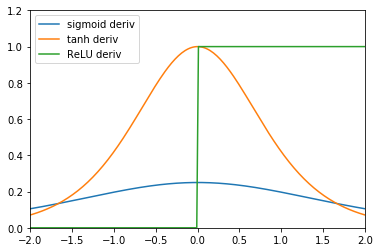

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
x = np.linspace(-10, 10, 1000)

# sigmoid
ax = fig.add_subplot(111)
ax.plot(x, deriv_sigmoid(x), label='sigmoid deriv')

# tanh
ax.plot(x, deriv_tanh(x), label='tanh deriv')

# relu
ax.plot(x, deriv_relu(x), label='ReLU deriv')

plt.legend()
plt.xlim(-2, 2)
plt.ylim(0, 1.2)
plt.show()

図より, sigmoidよりもtanh、reluのほうがより大きな値をとり、勾配消失しにくいことがわかります。

最近の論文でもreluもしくはその派生形を用いているものが多いです。

#### 3.2.3 初期化 (initializer)

勾配に関するテクニックの3つめはパラメータの初期化についてです。

各層のパラメータは0を中心とした乱数で初期化しますが、大きすぎる値で初期化すれば学習の初期段階での勾配が過大になり、

逆に小さすぎる値だと勾配自体も過小になってしまい、いずれにしても学習はうまく進みません。

そこで、初期化にあたっては、その値のスケール（分散）を適切に設定する必要があります。

このパラメータの初期化にあたって比較的頻繁に用いられる手法として、LeCunによる手法、Glorotによる手法、Heによる手法が挙げられます。

特にGlorotの初期化法は活性化関数が全て線形な場合の解析結果であり、中央付近が線形とみなせるsigmoid関数やtanh関数に適していると言えます。

また、Heの初期化法は活性化関数がReLUであるときに適しています。

##### LeCunの初期化

各層の入力次元を$n_{in}$として, 次のように初期化します.
$$
    \theta \sim \mathcal{U}\left(-\sqrt{\frac{3}{n_{\textrm{in}}}}, \sqrt{\frac{3}{n_{\textrm{in}}}}\right) \quad \textrm{or} \quad \mathcal{N}\left(0, \frac{1}{\sqrt{n_{\textrm{in}}}}\right)
$$

なお、$\mathcal{U}$は一様分布、$\mathcal{N}$は正規分布を表します。

Kerasでは、それぞれ`keras.initializers.lucun_uniform`、`keras.initializers.lucun_normal`として定義されていますが、

以下のようにlayerの引数としてキーワードで指定することも可能です。

```py
# LuCun's initializationの実装例
model.add(Dense(128, activation='relu', kernel_initializer='lucun_uniform'))
model.add(Dense(128, activation='relu', kernel_initializer='lucun_normal'))
```

参考：
https://keras.io/ja/initializers/#lecun_normal
https://keras.io/ja/initializers/#lecun_uniform

##### Glorotの初期化（Xavierの初期化）

各層の入力次元を$n_{\textrm{in}}$, 出力次元を$n_{\textrm{out}}$として, 次のように初期化します.
$$
    \theta \sim \mathcal{U}\left(-\sqrt{\frac{6}{n_{\textrm{in}}+n_{\textrm{out}}}}, \sqrt{\frac{6}{n_{\textrm{in}}+n_{\textrm{out}}}}\right) \quad \textrm{or} \quad \mathcal{N}\left(0, \sqrt{\frac{2}{n_{\textrm{in}}+n_{\textrm{out}}}}\right)
$$

なお、$\mathcal{U}$は一様分布、$\mathcal{N}$は正規分布を表します。

Kerasでは、それぞれ`keras.initializers.glorot_uniform`、`keras.initializers.glorot_normal`として定義されていますが、

以下のようにlayerの引数としてキーワードで指定することも可能です。

```py
# Glorot's initializationの実装例
model.add(Dense(128, activation='sigmoid', kernel_initializer='glorot_uniform'))
model.add(Dense(128, activation='sigmoid', kernel_initializer='glorot_normal'))
```

参考：
https://keras.io/ja/initializers/#glorot_normal
https://keras.io/ja/initializers/#glorot_uniform

##### Heの初期化

各層の入力次元を$n_{\textrm{in}}$として, 次のように初期化します.
$$
    \theta \sim \mathcal{U}\left(-\sqrt{\frac{6}{n_{\textrm{in}}}}, \sqrt{\frac{6}{n_{\textrm{in}}}}\right) \quad \textrm{or} \quad \mathcal{N}\left(0, \sqrt{\frac{2}{n_{\textrm{in}}}}\right)
$$

なお、$\mathcal{U}$は一様分布、$\mathcal{N}$は正規分布を表します。

Kerasでは、それぞれ`keras.initializers.he_uniform`、`keras.initializers.he_normal`として定義されていますが、

以下のようにlayerの引数としてキーワードで指定することも可能です。

```py
# He's initializationの実装例
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
```

参考：
https://keras.io/ja/initializers/#he_normal
https://keras.io/ja/initializers/#he_uniform

### 3.3 過学習に対するテクニック

ここでMLPの教師有り学習における真の目標を振り返っておきましょう。それは、新しく未知のデータが来た時に正確に予測することです。

一方で、我々がこれまで扱ってきたものは、学習＝既知のデータに対して正確に予測することです。

この違いは実は大きな問題となります。既知のデータへの予測精度を十分高めたからと言って、未知のデータへの予測精度が上がるとは限りません。

具体的には、学習がある程度以上進むと、次第に既知データが持つ、それ自身には意味がないような統計的なばらつきまで学習してしまい、

未知データへの予測精度が落ちるという現象、すなわち**過学習**が発生するわけです。

したがって、単に目的関数を訓練データに対して最小化すればよいという問題ではなくなってきます。

こうした過学習へのアプローチを3つほど取り上げたいと思います。

#### 3.3.1 正則化 (regularization)

過学習が発生する一つの理由は、MLPのモデルは特に多くのパラメータ・自由度を持つために、

訓練データに対して、その本質的な部分以上に統計的ばらつきまで含めて完全にフィットしようとしてしまうことにあります。 

そこで過学習を回避するには、学習過程でいくつかのパラメータが自動的に機能しなくなると良いわけですが、これを実現するのが**正則化**です。

具体的には、損失関数にパラメータの大きさに対するペナルティ項（正則化項）を含めます。

これにより, パラメータを自由に動けないように制限し、なるべく少ないパラメータでデータにフィットするようにできます。

（実際の挙動としては、パラメータの値が0に近づくようにするということです。0であればパラメータは実質的に機能しません。）

なお、正則化には様々な種類が存在し、主に次のL2,L1正則化またそれらを組み合わせたElasticNetが用いられます。

参考：https://keras.io/ja/regularizers/

##### L2正則化

L2正則化では、全パラメータの2乗和を正則化項として損失関数に加えます。

L2正則化では、パラメータを完全に0にすることは少ないものの、パラメータを滑らかにすることで予測精度のより良いモデルを構築します。

Kerasでは`keras.regularizers.l2`として定義されていますが、実際には各layerにregularizerとして引数で指定して用います。

なお、`keras.regularizers.l2`は引数として、正則化項に掛かる係数を指定できます。

```py
from keras.layers import Dense
from keras import regularizers
model.add(Dense(128, kernel_regularizer=regularizers.l2(0.01))
```

<small>

<参考>
$\Theta$：パラメータ、$\lambda$：係数（＝引数）
$$
    \mathrm{E}(\boldsymbol{w}) = \sum^{N}_{n=1}\sum^{K}_{k=1} t^{(n)}_{k} \ln y^{(n)}_k + \lambda \sum_{i}w_i^2
$$

</small>

##### L1正則化

L1正則化では、全パラメータの絶対値の和を正則化項として損失関数に加えます。

L1正則化ではL2正則化よりもパラメータが0になりやすいという特徴（**スパース性**）があります。

Kerasでは`keras.regularizers.l1`として定義されていますが、実際には各layerにregularizerとして引数で指定して用います。

なお、`keras.regularizers.l1`は引数として、正則化項に掛かる係数を指定できます。

```py
from keras.layers import Dense
from keras import regularizers
model.add(Dense(128, kernel_regularizer=regularizers.l1(0.01))
```
<small>

<参考>
$\boldsymbol{w}$：パラメータ、$\lambda$：係数（＝引数）
$$
    \mathrm{E}(\boldsymbol{w}) = \sum^{N}_{n=1}\sum^{K}_{k=1} t^{(n)}_{k} \ln y^{(n)}_k + \lambda \sum_{i}|w_i|
$$

</small>

##### ElasticNet

L1正則化とL2正則化の組み合わせです。

Kerasでは`keras.regularizers.l1_l2`として定義されていますが、実際には各layerにregularizerとして引数で指定して用います。

なお、`keras.regularizers.l1_l2`は引数として、各々の正則化項に掛かる係数を指定できます。

```py
from keras.layers import Dense
from keras import regularizers
model.add(Dense(128, kernel_regularizer=regularizers.l1_l2(l1=0.01,l2=0.01))
```
<small>

<参考>
$\boldsymbol{w}$：パラメータ、$\lambda$：係数、$\alpha$：L1正則化とL2正則化の割合
$$
    \mathrm{E}(\boldsymbol{w}) = \sum^{N}_{n=1}\sum^{K}_{k=1} t^{(n)}_{k} \ln y^{(n)}_k + \lambda \sum_{i}[\alpha|w_i|+(1-\alpha)w_i^2]
$$
よくある定義式としては上の通りですが、Kerasの実装との対応は、
$$
    l1=\lambda\alpha, \quad l2=\lambda(1-\alpha) \Leftrightarrow \lambda=l1+l2, \quad \alpha = \frac{l1}{l1+l2}
$$
</small>

実際に学習したモデルのコストをチェックする際は、正則化項を含めない値が他のモデルに比べて減っているかを見る必要があります。

というのも、正則化項はあくまで学習の都合上導入されたもので、予測の意味では、正則化項を含めない目的関数で評価すべきであるためです。

#### 3.3.2 早期終了 (early stopping)

下図の通り、過学習はある一定以上学習が進んでから発生します。

またこのとき、学習データによる評価関数値が改善しても、検証データによる評価関数値はさほど改善しないか悪化します。

![es](figures/earlystopping.png)

出典：https://deeplearning4j.org/earlystopping

つまり、過学習に突入してからの学習は、未知のデータに対する予測力に寄与しない、（統計的なばらつき等の）本質的でない部分の学習なわけです。

そこで、いっそのこと早々に学習を止めてしまうことで過学習を回避する手もあります。それが**早期終了(early stopping)**です。

といっても、具体的にいつ学習を止めるかが重要です。

先述の通り、訓練データに対する誤差は最適化によってほとんどの場合低下しますが、検証データの誤差は過学習時には上昇します。

そこで、検証データの誤差が大きくなってきた（或いは評価関数値が下がってきた）ところで学習をストップさせます。

`Keras`ではcallbackという機能を使って各エポック毎のモデルにパラメータを保存し、検証データのコストが大きくなったら前のエポックのパラメータを使用するようにします。

`model.fit`の引数に以下のように設定します。

```py
model.fit(x=x_train, y=y_train, ...,
    callbacks=keras.callbacks.EarlyStopping(patience=0, verbose=1))
```

参考：https://keras.io/ja/callbacks/#earlystopping

#### 3.3.3 ドロップアウト (dropout)

過学習で余計に学習している部分に着目すると、それは統計的なばらつきと言えるような部分でした。

こうした確率的なばらつきは、一般に大量に足し合わせると相殺されます。

そこで、訓練データセットから部分訓練データセットを大量に作成し、各モデルの予測結果を平均するアンサンブルという手法が用いられることがあります。

このアンサンブル法は大変魅力的な手法なのですが、とてつもない計算量を要するためそのまま用いることは難しいものでした。

そこで出てきたものが、**ドロップアウト (dropout)**と呼ばれる手法で、これは近似的にアンサンブル法を実現するものになっています。

具体的には、ドロップアウトは入力の一部をランダムに0にして出力するlayerの一種です。要するに一部のユニットを取り除いた状況を再現します。

このユニットの除去を確率的に行い、一部のユニットが除去された部分ネットワークに対して学習することを繰り返すことで、

多数のモデルを同時に訓練することと同じ効果を再現しているわけです。

Kerasでは、`keras.layers.core.Dropout`クラスを用いて実装できます。

```py
keras.layers.core.Dropout(rate, noise_shape=None, seed=None)
```

主な引数は、

* rate: 入力を0にする確率、0～1の実数値
* seed: 乱数のシード値

です。（入力と出力でshapeは変わりません）

参考：https://keras.io/ja/layers/core/#dropout

### 3.4 確認問題

1. 損失関数のパラメータ微分のことを何というか  
  ①スケーリング　②勾配　③学習率　④SGD
2. 活性化関数の選択により対処可能な問題を何というか  
  ①勾配消失問題　②次元の呪い　③固有値問題　④バイアス―バリアンストレードオフ
3. 損失関数にペナルティ項を加え、パラメータの自由度を下げる手法を何というか  
  ①モーメンタム　②部分空間法　③正則化　④誤差逆伝播法
4. 過学習への対処としてふさわしくないものはどれか  
  ①ドロップアウト　②スケーリング　③ElasticNet　④早期終了

回答
1. 勾配
2. 勾配消失問題
3. 正則化
4. スケーリング